We saw some differences betweent results reported in [Beissinger](https://www.nature.com/articles/nplants201684) and our paper. Was it differences in the data or methods? 

Beissinger related pi in a window to distance from nearest gene (in cM). Going to redo that appraoch on our data here to see if we find similar or different patterns.  

In [1]:
library(GenomicRanges)
library(tidyverse)
library(cowplot)
library(Rcpp)
library(purrr)
library(tidyr)
theme_set(cowplot::theme_cowplot())
library(patchwork)
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)


##Pasting the useful functions and data from BGSmodeling here

#Reading in our PI Data
read_angsd_pi = function(pi_file, minimum_sites = 0.01){
  vroom::vroom(
    pi_file, skip = 1,
    col_names = c("info", "chr", "WinCenter", "tW","tP","tF","tH","tL","Tajima","fuf","fud","fayh","zeng","nSites")) %>%
    separate(info, sep = "[\\)\\(,]", into = c(letters[1:7], "WinStart", "WinStop", "g2")) %>% 
    dplyr::select(-c(letters[1:7], g2)) %>%
    mutate(start = as.numeric(WinStart), 
           end = as.numeric(WinStop),
           size = end - start) %>% 
    na.omit() %>% 
    mutate(pi = tP / nSites) %>% 
    filter(pi > 0, nSites > minimum_sites*size) %>%
    dplyr::select(chr, start, end, pi)     
}

#!!!REQUIRES ALL INPUT DFS INCLUDE COLUMN NAMES: chr, start, end
CM <- function(genetic_df, pi_df){
  tibble(
  cm_start = approx(x = genetic_df$pos, y = genetic_df$cm, xout = pi_df$start)$y,
  cm_end = approx(x = genetic_df$pos, y = genetic_df$cm, xout = pi_df$end)$y,
  cm_mid = (cm_start + cm_end)/2,
  cm_mb = approx(x = genetic_df$pos, y = genetic_df$cm_mb, xout = (pi_df$start + pi_df$end)/2)$y,
  rec = cm_end - cm_start
  )
}


pi_files <- list.files(path = "../data/angsd_pi", pattern = "(100000)BP_theta.txt", full.names = TRUE)
pops <- str_replace(pi_files, "../data/angsd_pi/(..*)_theta.txt", "\\1")

#file_df <- separate(tibble(file = pi_files, x = pi_files), x, sep = "--|\\.", into = c("a", "b", "path", "ssp", "pop", "chrom", "start", "end", "bp", "j", "k", "l")) %>% 
#mutate(ssp_pop = str_glue("{ssp}_{pop}"),
#      ssp_pop_bp = str_glue("{ssp}_{pop}_{bp}"))

gen_map_all_chr <- read_delim("../data/map/ogut_v5.map.txt", delim = "\t") %>% 
  drop_na() %>%
  mutate(cm = cm + abs(min(cm))) %>%
  group_by(chr) %>% 
  group_modify(~{
    df1 <- slice(.x, -nrow(.x))
    df2 <- slice(.x, -1)
    to_keep <- df2$cm > df1$cm & df2$pos > df1$pos
    df1 <- df1[to_keep, ]
    df2 <- df2[to_keep, ]
    cm_mb <- tibble(cm_mb = 1e6*(df2$cm - df1$cm)/(df2$pos - df1$pos))
    bind_cols(df2, cm_mb)
  }) %>% 
  mutate(chr = paste0("chr", chr))


#made with 
#zcat < data/refs/v5/v5.gff3.gz | grep "P001" | bedtools sort -i stdin | bedtools merge -i stdin > data/refs/v5_functional.bed
gff_test <- vroom::vroom(
  "../data/refs/v5_functional.bed", 
  delim = "\t",
  comment = "#", 
  col_names = c("chr", "start", "end")
  )

chrms <- paste0("chr", 1:10)

head(gff_test); head(gen_map_all_chr)



Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The

chr,start,end
<chr>,<dbl>,<dbl>
chr1,34616,35318
chr1,36036,36174
chr1,36258,36504
chr1,36599,36713
chr1,36821,37004
chr1,37415,37633


chr,pos,cm,cm_mb
<chr>,<dbl>,<dbl>,<dbl>
chr1,214369,3.4,2.246181
chr1,341276,3.6,1.575957
chr1,370511,3.8,6.841115
chr1,532547,4.2,2.468587
chr1,603370,4.4,2.823941
chr1,694670,4.6,2.190581


In [2]:
closest_cds_df <- 
pi_files %>% map_df(~{
    
    pop <- .x %>% str_remove_all('(../data/angsd_pi/v5--|.100000BP_theta.txt)')

    pi_test <- read_angsd_pi(.x, minimum_sites = 0.01)

    pi_ranges <- GRanges(pi_test$chr, IRanges(pi_test$start, pi_test$end), pi = pi_test$pi)
    gff_ranges <- GRanges(gff_test$chr, IRanges(gff_test$start, gff_test$end))

    cloest_gff_ranges <- gff_ranges[nearest(pi_ranges, gff_ranges),]
    cds_gap_df <- data.frame(pgap(pi_ranges, cloest_gff_ranges)) %>% 
        rename(chr = seqnames)

    cm_df <- CM(gen_map_all_chr, cds_gap_df)
    cm_gap <- cm_df$cm_start - cm_df$cm_end 
    mutate(pi_test, cm = cm_gap, ssp_pop = pop) %>% drop_na(cm, pi)
}) %>% 
    mutate(splitme = ssp_pop) %>% 
    separate(splitme, c("ssp", "pop"), "--")

Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 21,302
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specif

`summarise()` has grouped output by 'genic'. You can override using the `.groups` argument.




Call:
lm(formula = pi ~ genic * ssp, data = mutate(closest_cds_df, 
    genic = ifelse(cm == 0, "genic", "non-genic")))

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0085803 -0.0016814  0.0000998  0.0016889  0.0108572 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            6.249e-03  8.942e-05  69.884   <2e-16 ***
genicnon-genic         1.853e-04  8.962e-05   2.068   0.0386 *  
sspTeo                 2.475e-03  1.229e-04  20.135   <2e-16 ***
genicnon-genic:sspTeo -4.449e-06  1.232e-04  -0.036   0.9712    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.002465 on 361025 degrees of freedom
Multiple R-squared:  0.2001,	Adjusted R-squared:  0.2001 
F-statistic: 3.011e+04 on 3 and 361025 DF,  p-value: < 2.2e-16



Call:
lm(formula = pi ~ genic * ssp, data = match_df)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0076939 -0.0017091  0.0000943  0.0018198  0.0068410 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.0061851  0.0001337  46.258   <2e-16 ***
genicnon-genic         0.0002875  0.0001891   1.520    0.129    
sspTeo                 0.0027662  0.0001891  14.629   <2e-16 ***
genicnon-genic:sspTeo -0.0003929  0.0002674  -1.469    0.142    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.002512 on 1408 degrees of freedom
Multiple R-squared:  0.209,	Adjusted R-squared:  0.2073 
F-statistic:   124 on 3 and 1408 DF,  p-value: < 2.2e-16


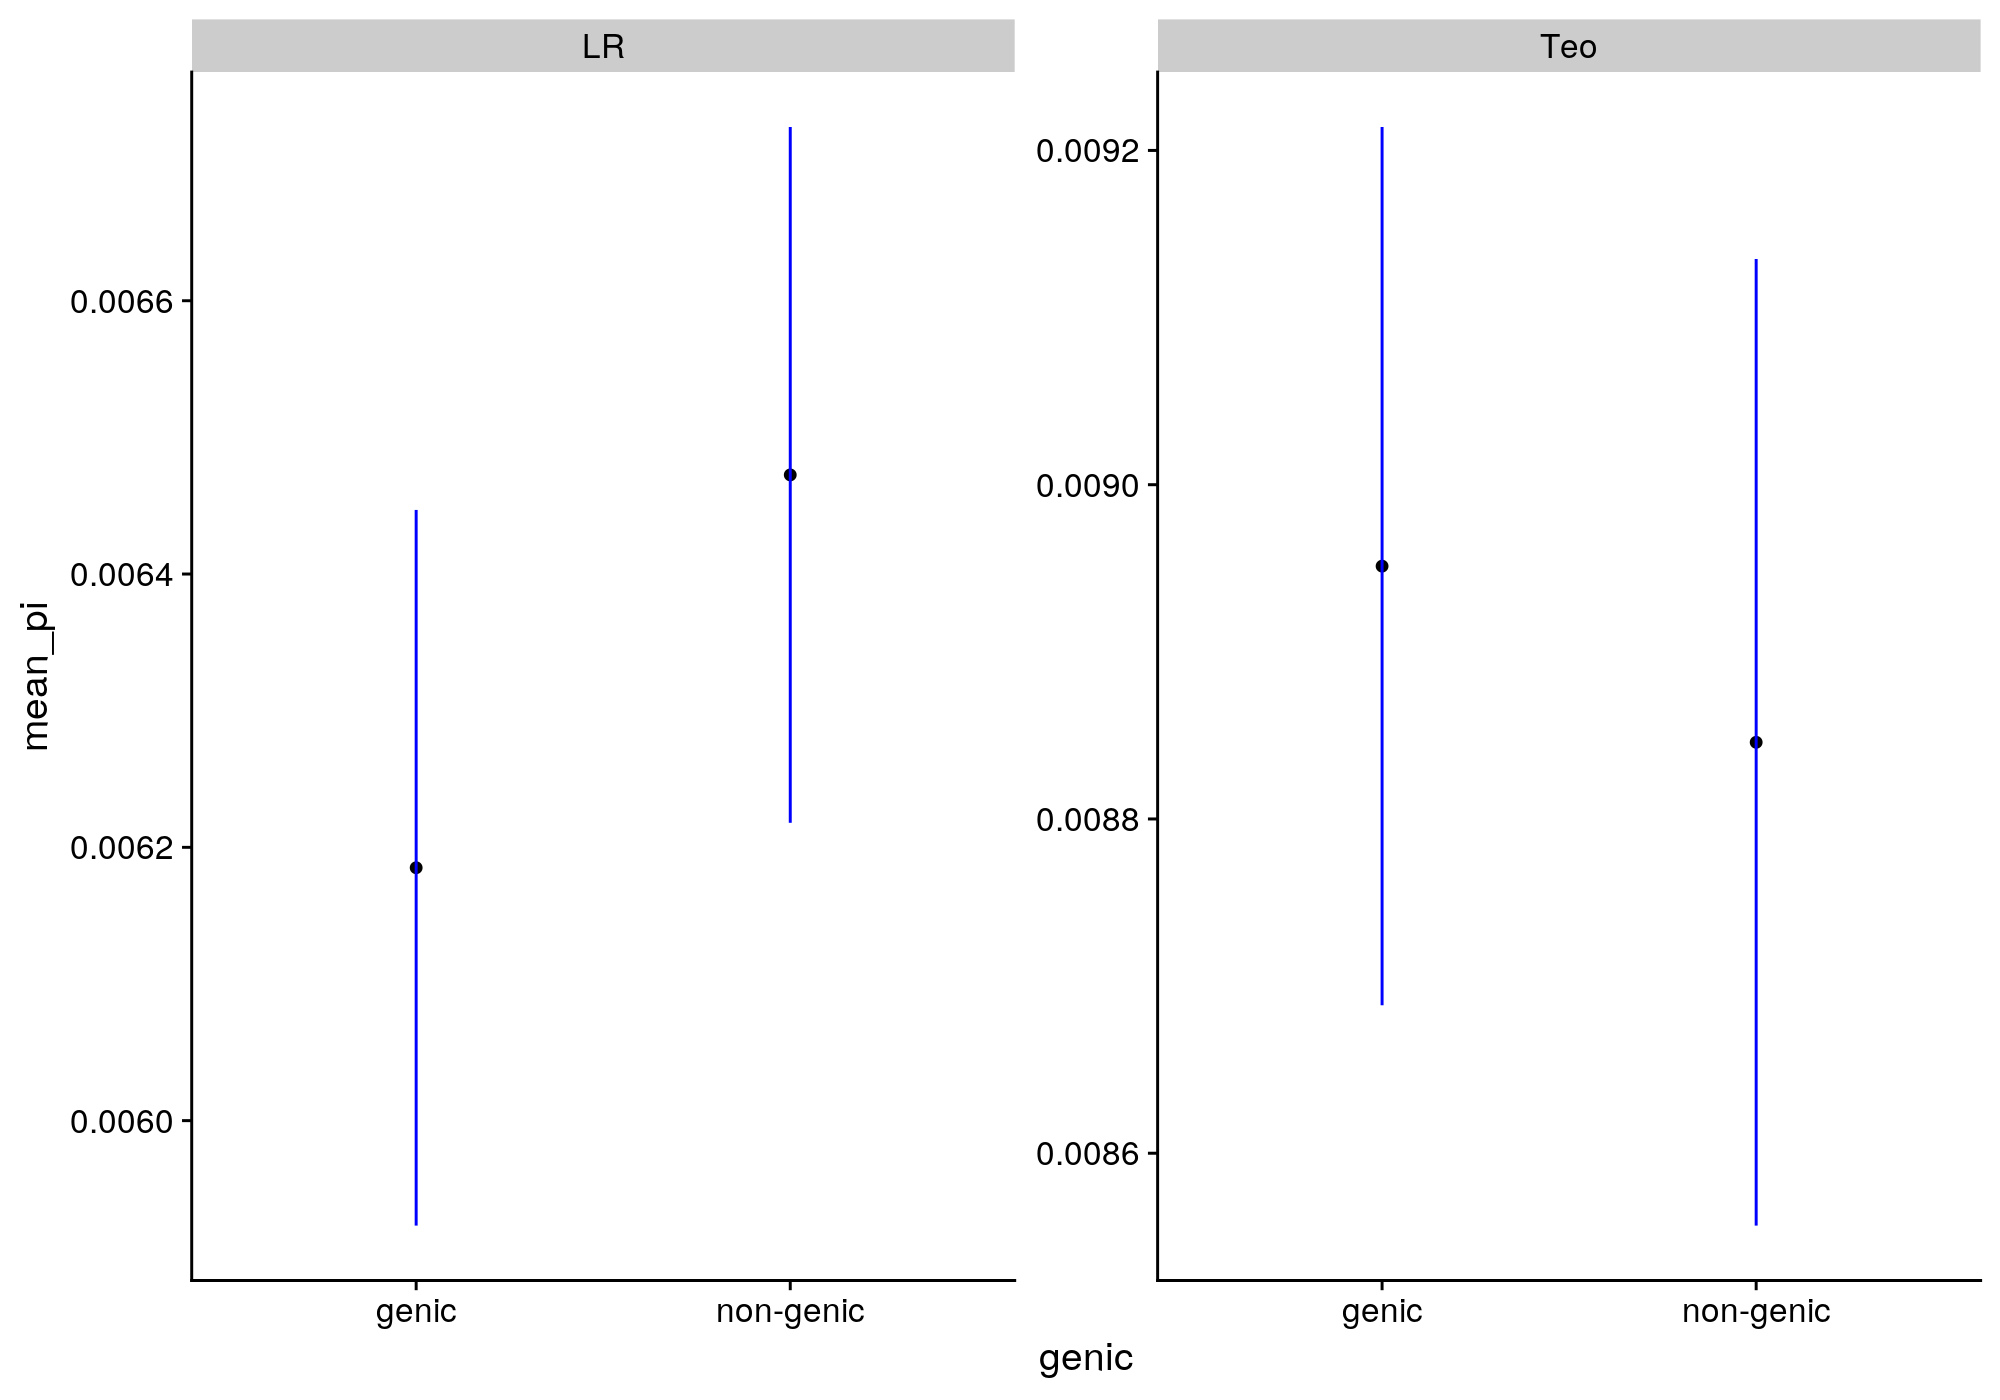

In [3]:
match_df  <- 
closest_cds_df %>% 
    mutate(genic = ifelse(cm == 0, "genic", "non-genic")) %>%
    group_by(genic, ssp) %>% 
    sample_n(353)

ci_df <- 
match_df %>% 
    summarise(
        mean_pi = mean(pi), 
        low_ci = mean_pi - 2*sd(pi)/sqrt(n()),
        hi_ci = mean_pi + 2*sd(pi)/sqrt(n())
    )


summary(lm(pi ~ genic*ssp, data = mutate(closest_cds_df, genic = ifelse(cm == 0, "genic", "non-genic"))))
summary(lm(pi ~ genic*ssp, data = match_df))

ci_df %>% 
    ggplot() +
    geom_point(aes(genic, mean_pi)) +
    geom_segment(aes(x = genic, y = low_ci, xend = genic, yend = hi_ci), colour = "blue") +
    facet_wrap(~ssp, scales = "free")

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



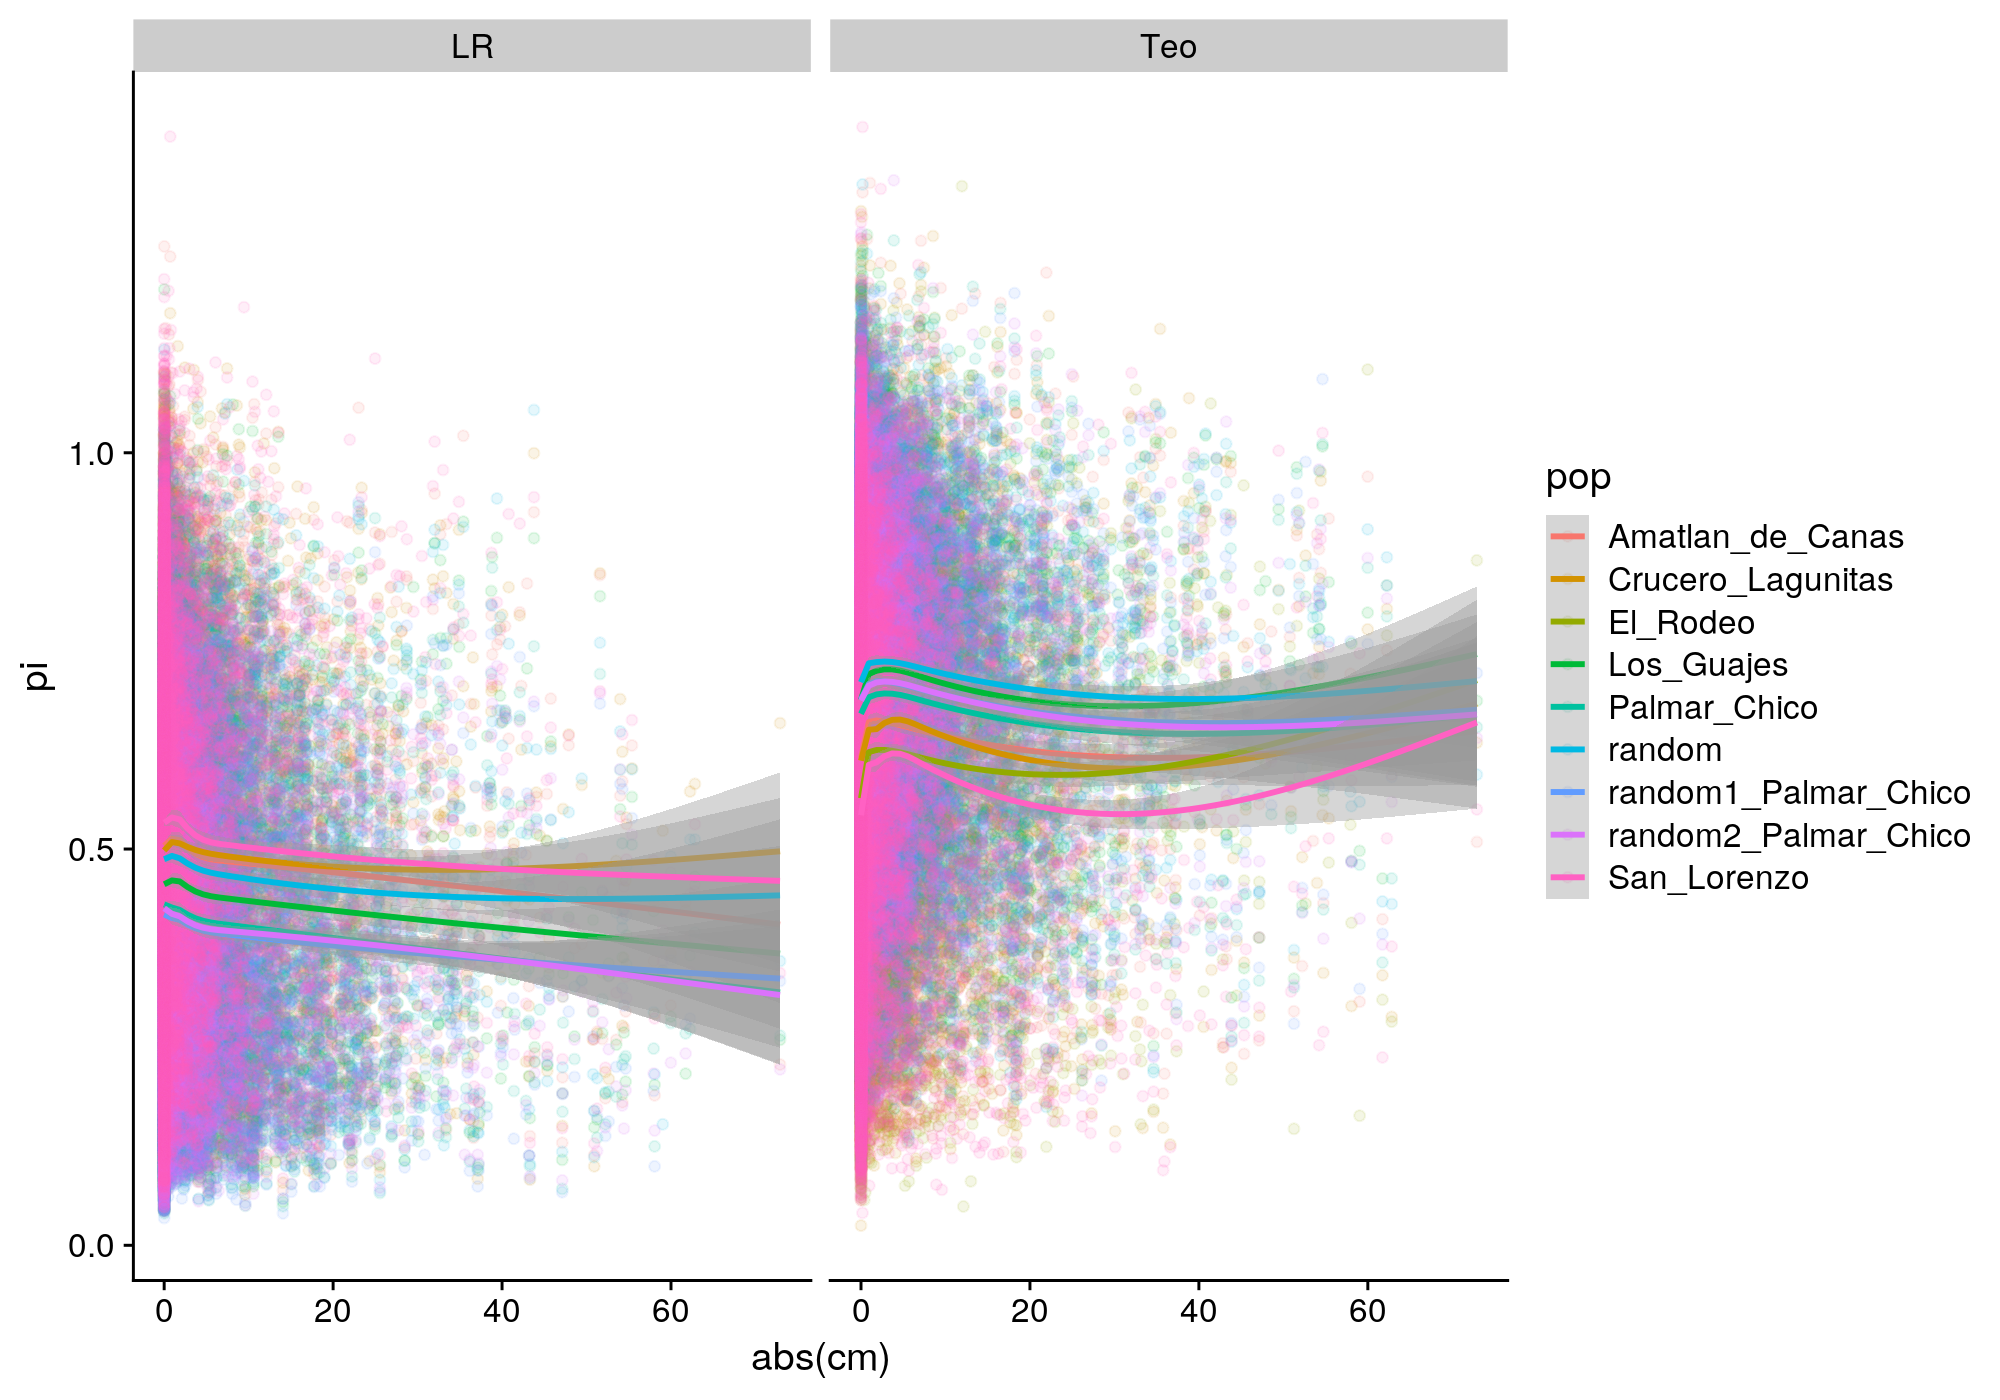

In [4]:
closest_cds_df %>% 
    group_by(pop) %>% 
    filter(cm >= -Inf) %>% 
    mutate(pi = pi/quantile(pi, 0.99)) %>% 
    ggplot(aes(abs(cm), pi, colour = pop)) +
    geom_point(alpha = 0.1) +
    geom_smooth() +
    facet_wrap(~ssp)